In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import ta
import matplotlib.pyplot as plt

In [81]:
df = yf.download('BTC-USD', start='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [82]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


In [83]:
df['ma_20'] = df.Close.rolling(20).mean()
df['vol'] = df.Close.rolling(20).std()
df['upper_bb'] = df.ma_20 + (2 * df.vol)
df['lower_bb'] = df.ma_20 - (2 * df.vol)
df['rsi'] = ta.momentum.rsi(df.Close, window=6)

In [84]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ma_20,vol,upper_bb,lower_bb,rsi
Date,,,,,,,,,,,
2023-01-08,16954.146484,17091.144531,16924.050781,17091.144531,17091.144531,9768827914,16785.721289,148.191180,17082.103648,16489.338930,77.327125
2023-01-09,17093.992188,17389.957031,17093.992188,17196.554688,17196.554688,18624736866,16800.233789,172.791837,17145.817463,16454.650115,81.762435
2023-01-10,17192.949219,17484.720703,17162.990234,17446.292969,17446.292969,15808338949,16831.671680,225.319617,17282.310914,16381.032445,88.280421
2023-01-11,17446.359375,17934.896484,17337.994141,17934.896484,17934.896484,18372283782,16886.899414,334.090345,17555.080104,16218.718724,93.627450
2023-01-12,17925.808594,18265.669922,17922.865234,18202.962891,18202.962891,24395395072,16957.199902,444.012825,17845.225552,16069.174253,95.099462


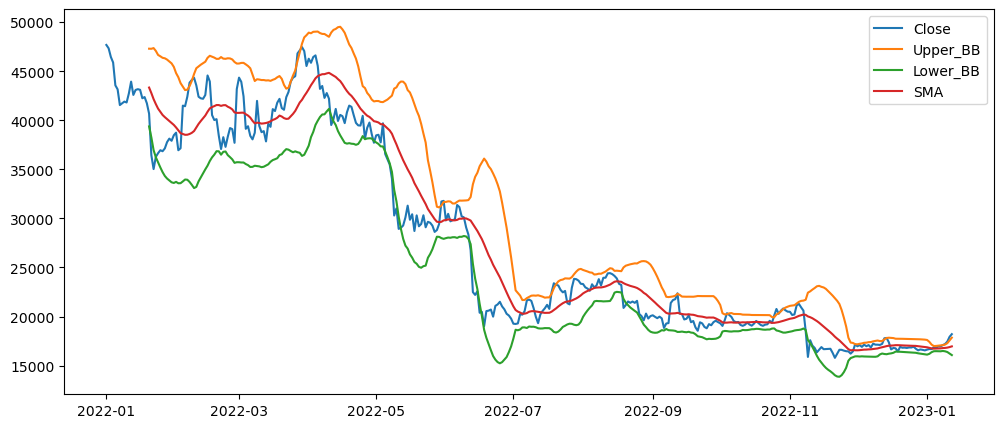

In [85]:
plt.figure(figsize=(12, 5))
plt.plot(df['2022':][['Close', 'upper_bb', 'lower_bb', 'ma_20']], label = ['Close', 'Upper_BB', 'Lower_BB', 'SMA'])
plt.legend()

In [86]:
conditions = [(df.rsi < 30) & (df.Close < df.lower_bb),
              (df.rsi > 70) & (df.Close > df.upper_bb)]
choices = ['Buy', 'Sell']

In [87]:
df['signal'] = np.select(conditions, choices)

In [88]:
df.dropna(inplace=True)

In [89]:
df.signal = df.signal.shift()

In [90]:
df['shifted_close'] = df.Close.shift()

In [91]:
position = False

buydate, selldate = [], []
buyprice, sellprice = [], []

for index, row in df.iterrows():
    if not position and row['signal'] == 'Buy':
        buydate.append(index)
        buyprice.append(row.Open)
        position = True
    if position:
        if row['signal'] == 'Sell' or row.shifted_close < 0.95 * buyprice[-1]:
            selldate.append(index)
            sellprice.append(row.Open)
            position = False

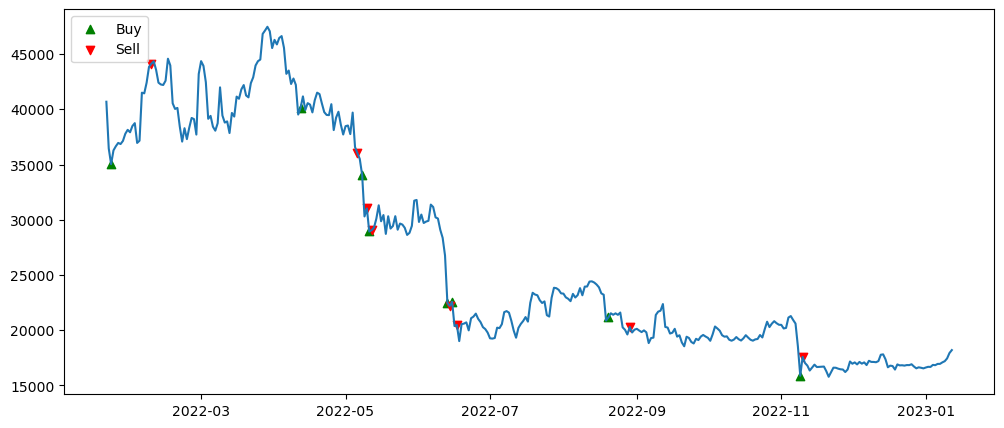

In [92]:
plt.figure(figsize=(12, 5))
plt.plot(df.Close)
plt.scatter(df.loc[buydate].index, df.loc[buydate].Close, marker='^', color='g', label = 'Buy')
plt.scatter(df.loc[selldate].index, df.loc[selldate].Close, marker='v', color='r', label = 'Sell')
plt.legend(loc='upper left')

In [93]:
MeanReversion = (pd.Series([(sell - buy) / buy for sell,buy in zip(sellprice, buyprice)]) + 1).prod()
buyHold = (df['Adj Close'].pct_change() + 1).prod()

print(f'Mean Reversion: {MeanReversion}\nBuy/hold: {buyHold}\nDifference: {MeanReversion - buyHold}')

Mean Reversion: 0.5502150699437013
Buy/hold: 0.44746253356118965
Difference: 0.10275253638251164


In [15]:
# coppock curve